In [1]:
from train_dnn import get_data
import torch
from data import adult
from torch.utils.data import DataLoader
from dnn_models.model import MLP
from utils import load_model
import os

def load_data_and_model(model_id, use_protected_attr, protected_vars):
    dataset, train_loader, test_loader = get_data(adult, model_id, protected_vars)
    dataset.use_protected_attr = use_protected_attr
    all_X= dataset.get_all_data()

    in_dim = dataset.dim_feature()
    out_dim = 2

    model = MLP(in_dim, out_dim)
    load_model(model, 'MLP', 'adult', 'STDTrainer', use_protected_attr=use_protected_attr, \
               protected_vars=protected_vars, id=model_id)
    return model, dataset, all_X, train_loader, test_loader

def get_logits(model, X):
    if isinstance(X, torch.Tensor):
        return model(X)
    elif isinstance(X, DataLoader):
        logits = torch.Tensor()
        for batch in X:
            logits = torch.concat([logits, model(batch[0])], dim=0)
        return logits

In [2]:
model, dataset, all_X, train_loader, test_loader = load_data_and_model(0, True, ['sex_Male'])

In [3]:
logits_train = get_logits(model, train_loader)

In [4]:
logits_test = get_logits(model, test_loader)

In [5]:
logits_all = get_logits(model, all_X)

In [6]:
def get_log_pairs(log_path):
    with open(os.path.join('log', f'{log_path}.log'),'r') as f:
        lines = f.readlines()
        pairs = torch.Tensor()
        for line in lines[1:]:
            t, s, n, p = line.split('\t')
            p = torch.tensor(eval(p))
            pairs = torch.concat([pairs, p], dim=0)
        return torch.Tensor(pairs)

In [7]:
weird_data = get_log_pairs('eu_black')

In [8]:
# weird_data = weird_data[
#     torch.logical_and(weird_data[:, 0]>=90, weird_data[:, 4]>=70)
# ]

In [9]:
display(adult.get_original_feature(weird_data))

,age,capital-gain,capital-loss,education-num,hours-per-week,race_White,sex_Male,marital-status,occupation,relationship,workclass
0,73.0,0.0,4356.0,1.0,85.0,1.0,0.0,4.0,7.0,1.0,2.0
1,56.0,0.0,4356.0,1.0,70.0,1.0,0.0,4.0,7.0,1.0,2.0
2,73.0,0.0,4356.0,1.0,85.0,1.0,0.0,4.0,7.0,1.0,2.0
3,56.0,0.0,4356.0,1.0,70.0,1.0,0.0,4.0,7.0,1.0,2.0
4,90.0,12479.0,0.0,16.0,99.0,1.0,0.0,4.0,7.0,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...
1995,56.0,0.0,4356.0,1.0,70.0,1.0,0.0,4.0,7.0,1.0,2.0
1996,90.0,18133.0,0.0,16.0,99.0,1.0,0.0,4.0,7.0,1.0,2.0
1997,90.0,2532.0,0.0,16.0,99.0,1.0,0.0,4.0,7.0,1.0,2.0
1998,90.0,10937.0,0.0,16.0,99.0,1.0,0.0,4.0,7.0,1.0,2.0


In [10]:
logits_weird = get_logits(model, weird_data)

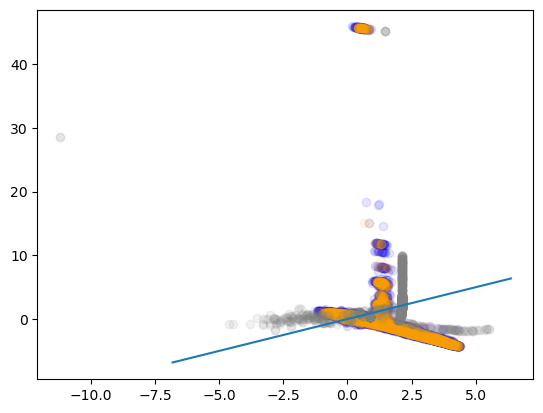

In [11]:
import matplotlib.pyplot as plt
import numpy as np
data_points = lambda x: (x[:, 0].detach().numpy(), x[:, 1].detach().numpy())

fig, ax = plt.subplots()
ax.scatter(*data_points(logits_train), c='blue', alpha=0.1)
ax.scatter(*data_points(logits_test), c='orange', alpha=0.1)
ax.scatter(*data_points(logits_weird), c='gray', alpha=0.1)
x_range = ax.get_xlim()
y_range = ax.get_ylim()
x1 = max(x_range[0], y_range[0])
x2 = min(x_range[1], y_range[1])
ax.plot([x1, x2], [x1, x2])

1. 多试几组：不同训练结果、不同的输入维度
2. 筛选真的不靠谱的数据

In [12]:
weird_data = weird_data[
    torch.logical_and(weird_data[:, 0]>=90, weird_data[:, 4]>=70)
]
logits_weird = get_logits(model, weird_data)

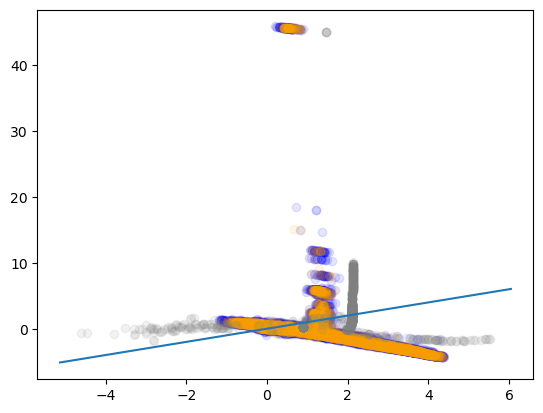

In [13]:
fig, ax = plt.subplots()
ax.scatter(*data_points(logits_train), c='blue', alpha=0.1)
ax.scatter(*data_points(logits_test), c='orange', alpha=0.1)
ax.scatter(*data_points(logits_weird), c='gray', alpha=0.1)
x_range = ax.get_xlim()
y_range = ax.get_ylim()
x1 = max(x_range[0], y_range[0])
x2 = min(x_range[1], y_range[1])
ax.plot([x1, x2], [x1, x2])

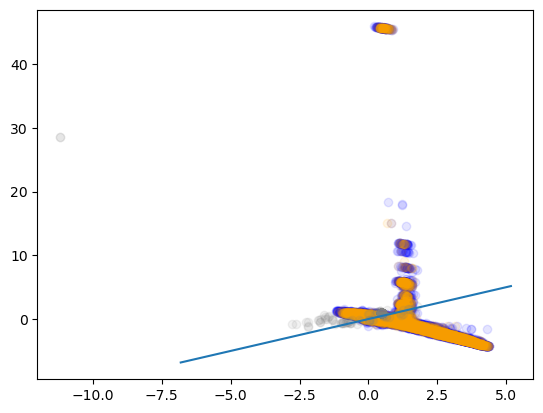

In [14]:
weird_data = get_log_pairs('eu_black')
weird_data = weird_data[
    torch.logical_or(weird_data[:, 0]<90, weird_data[:, 4]<70)
]
logits_weird = get_logits(model, weird_data)

fig, ax = plt.subplots()
ax.scatter(*data_points(logits_train), c='blue', alpha=0.1)
ax.scatter(*data_points(logits_test), c='orange', alpha=0.1)
ax.scatter(*data_points(logits_weird), c='gray', alpha=0.1)
x_range = ax.get_xlim()
y_range = ax.get_ylim()
x1 = max(x_range[0], y_range[0])
x2 = min(x_range[1], y_range[1])
ax.plot([x1, x2], [x1, x2])

In [15]:
display(adult.get_original_feature(weird_data))

,age,capital-gain,capital-loss,education-num,hours-per-week,race_White,sex_Male,marital-status,occupation,relationship,workclass
0,73.0,0.0,4356.0,1.0,85.0,1.0,0.0,4.0,7.0,1.0,2.0
1,56.0,0.0,4356.0,1.0,70.0,1.0,0.0,4.0,7.0,1.0,2.0
2,73.0,0.0,4356.0,1.0,85.0,1.0,0.0,4.0,7.0,1.0,2.0
3,56.0,0.0,4356.0,1.0,70.0,1.0,0.0,4.0,7.0,1.0,2.0
4,73.0,0.0,4356.0,1.0,85.0,1.0,0.0,4.0,7.0,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...
808,56.0,0.0,4356.0,1.0,70.0,1.0,0.0,4.0,7.0,1.0,2.0
809,73.0,0.0,4356.0,1.0,85.0,1.0,0.0,4.0,7.0,1.0,2.0
810,56.0,0.0,4356.0,1.0,70.0,1.0,0.0,4.0,7.0,1.0,2.0
811,73.0,0.0,4356.0,1.0,85.0,1.0,0.0,4.0,7.0,1.0,2.0
